## Regularization

In [2]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cross_validation import train_test_split
from sklearn.utils import check_random_state
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
    
from nose.tools import assert_equal, assert_is_not
from numpy.testing import assert_array_equal, assert_almost_equal, assert_array_almost_equal
from pandas.util.testing import assert_frame_equal

sns.set(style="white", font_scale=2.0)

In [3]:
filename = '2001.csv'

usecols = (5, 15, 16)
columns = ['CRSDepTime', 'DepDelay', 'Origin']

all_data = pd.read_csv(filename, header=0, na_values=['NA'], usecols=usecols, names=columns)

local = all_data.loc[all_data['Origin'] == 'ORD'].dropna()

In [4]:
def get_hourly(df):
    return df.groupby(pd.cut(df['CRSDepTime'], np.arange(0, 2400, 100))).mean().dropna()

hourly = get_hourly(local)
print(hourly)

               CRSDepTime   DepDelay
CRSDepTime                          
(500, 600]     595.588556   1.160309
(600, 700]     649.187489   1.922079
(700, 800]     740.461376   4.788713
(800, 900]     838.512038   6.073624
(900, 1000]    941.117287   7.533417
(1000, 1100]  1029.092318   7.959812
(1100, 1200]  1143.347120   8.945600
(1200, 1300]  1237.310490   9.465208
(1300, 1400]  1330.703802  10.080120
(1400, 1500]  1444.372347  12.928801
(1500, 1600]  1528.276364  14.855922
(1600, 1700]  1647.206659  15.155163
(1700, 1800]  1737.540096  16.915603
(1800, 1900]  1836.121684  18.688567
(1900, 2000]  1936.516002  20.037355
(2000, 2100]  2040.102539  18.882328
(2100, 2200]  2131.162948  18.011156
(2200, 2300]  2210.144461  13.627994


### Plot a linear regression model

In [130]:
def plot_seaborn_reg(df):
    '''
    Uses Seaborn to create a scatter plot of "DepDelay" vs "CRSDepTime" columns in "df".
    Also fits a linear regression model in the same plot.
    
    Parameters
    ----------
    df: A pandas.DataFrame. Should have columns named "CRSDepTime" and "DepDelay".
    
    Returns
    -------
    A matplotlib Axes object
    '''
    
    ax = sns.regplot(df['CRSDepTime'], df['DepDelay'], fit_reg=True)
    ax.set(title='Seaborn regression',
           xlabel='Scheduled departure time (local, hhmm)', 
           xlim=(500,2500),
           ylabel='Departure delay (min)', ylim=(-5,30))
    return ax

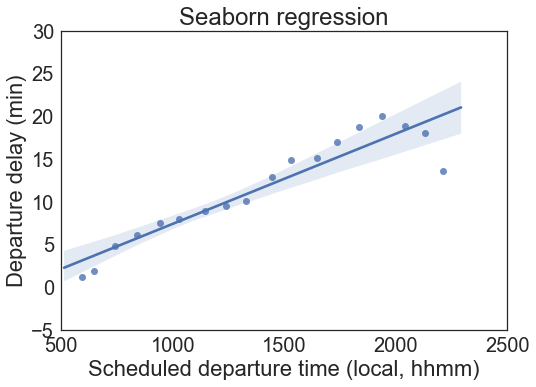

In [131]:
ax1 = plot_seaborn_reg(hourly)

In [132]:
assert_equal(isinstance(ax1, mpl.axes.Axes), True, msg="Your function should return a matplotlib.axes.Axes object.")

assert_equal(len(ax1.lines), 1)
assert_equal(len(ax1.collections), 2, msg="Your plot doesn't have a regression line.")

assert_is_not(len(ax1.title.get_text()), 0, msg="Your plot doesn't have a title.")
assert_is_not(ax1.xaxis.get_label_text(), "CRSDepTime", msg="Change the x-axis label to something more descriptive.")
assert_is_not(ax1.yaxis.get_label_text(), "DepDelay", msg="Change the y-axis label to something more descriptive.")
    
x_axis, y_axis = ax1.collections[0].get_offsets().T
assert_array_equal(x_axis, hourly["CRSDepTime"])
assert_array_equal(y_axis, hourly["DepDelay"])

### Fit a polynomial

In [12]:
def fit_reg_poly(df, degree, alpha=1.0,  max_iter=1000):
    '''
    Fits a ridge regression model on "CRSDepTime" to predict "DepDelay".
    
    Parameters
    ----------
    df: A pandas.DataFrame. Must have columns "CRSDepTime" and "DepDelay"
    
    Returns
    -------
    A tuple of (sklearn.Pipeline object, numpy.ndarray)
    '''
    
    est = make_pipeline(PolynomialFeatures(degree), Lasso(alpha=alpha,max_iter=max_iter))
    est.fit(df[['CRSDepTime']], df['DepDelay'])
    prediction=est.predict(df[['CRSDepTime']])[:, np.newaxis]
    return est, prediction

In [13]:
est1, pred1 = fit_reg_poly(hourly, 1, alpha=0.1)
est1_params = est1.get_params()
answer1 = np.array([[  3.12076375],
       [  3.68635785],
       [  4.64951082],
       [  5.68417463],
       [  6.76689997],
       [  7.6952423 ],
       [  8.90089767],
       [  9.89243099],
       [ 10.87794885],
       [ 12.07741784],
       [ 12.96280146],
       [ 14.21779423],
       [ 15.17102325],
       [ 16.21128956],
       [ 17.27068441],
       [ 18.36376465],
       [ 19.32466493],
       [ 20.15810461]])
assert_equal(est1_params['polynomialfeatures__degree'], 1)
assert_equal(est1_params['lasso__alpha'], 0.1)
assert_array_almost_equal(pred1, answer1)

est2, pred2 = fit_reg_poly(hourly, 2, alpha=1)
est2_params = est2.get_params()
answer2 = np.array([[  0.9892996 ],
       [  2.02149715],
       [  3.70465785],
       [  5.40809664],
       [  7.07455156],
       [  8.40883505],
       [ 10.01138571],
       [ 11.21898759],
       [ 12.32058151],
       [ 13.52858917],
       [ 14.3267865 ],
       [ 15.32215064],
       [ 15.97156988],
       [ 16.57525611],
       [ 17.07738524],
       [ 17.47631674],
       [ 17.72704719],
       [ 17.86877765]])
assert_equal(est2_params['polynomialfeatures__degree'], 2)
assert_equal(est2_params['lasso__alpha'], 1)
assert_array_almost_equal(pred2, answer2)

### Find the best fit model

In [14]:
def find_mse(df, degree):
    '''
    Computes mean squared error of a Ridge Regression model on "df".
    Uses the "fit_reg_poly()" function.
    
    Parameters
    ----------
    df: A pandas.DataFrame. Must have columns "CRSDepTime" and "DepDelay"

    Returns
    -------
    A float.
    '''
    
    pred = fit_reg_poly(df, degree, alpha=1.0)[1]
    mse=mean_squared_error(df['DepDelay'][:, np.newaxis],pred)
    return mse

In [15]:
degrees = list()
for i in range(1, 15):
    degrees.append(find_mse(hourly, i))

best_degree = np.argmin(degrees) + 1 # because degree = 1 corresponds to arg = 0
print('The best model is a polynomial of degree {}.'.format(best_degree))

The best model is a polynomial of degree 14.


In [16]:
assert_almost_equal(find_mse(hourly, 1), 4.18137098)
assert_almost_equal(find_mse(hourly, 2), 2.56271490)
assert_almost_equal(find_mse(hourly, 3), 2.05451124)
assert_almost_equal(find_mse(hourly, 4), 1.54515768)
assert_almost_equal(find_mse(hourly, 5), 1.30647284)

### Plot the lasso regression model

In [26]:
def plot_reg_ploy(df, degree):
    '''
    Plots the follwoing:
    1. A scatter plot of the "CRSDepTime" column of "df" on the x-axis
       and the "DepDelay" column of "df" on the y-axis,
    2. A line that represents a polynomial of degree "degree".
              
    Parameters
    ----------
    df: A pandas.DataFrame
    
    Returns
    -------
    A matplotlib.Axes object
    '''
    
    ax = sns.regplot(df["CRSDepTime"], df['DepDelay'],fit_reg=False)
    est,pred=fit_reg_poly(hourly, degree, alpha=1.0)
    plt.plot(df["CRSDepTime"],pred,c='g')
    ax.set(title='Regularized polynomial regression',
           xlabel='Scheduled departure time (hhmm)', xlim=(500, 2500),
           ylabel='Departure delay (mins)', ylim=(0, 25))
    return ax

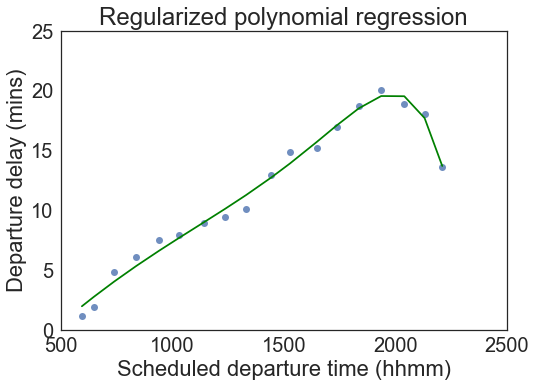

In [27]:
ax2 = plot_reg_ploy(hourly, best_degree)

In [28]:
assert_equal(isinstance(ax2, mpl.axes.Axes), True, msg="Your function should return a matplotlib.axes.Axes object.")

assert_equal(len(ax2.lines), 1)
assert_equal(len(ax2.collections), 1, msg="You should turn off Seaborn regression.")

assert_is_not(len(ax2.title.get_text()), 0, msg="Your plot doesn't have a title.")
assert_is_not(ax2.xaxis.get_label_text(), "AirTime", msg="Change the x-axis label to something more descriptive.")
assert_is_not(ax2.yaxis.get_label_text(), "Distance", msg="Change the y-axis label to something more descriptive.")
    
x_scatter, y_scatter = ax2.collections[0].get_offsets().T
assert_array_equal(x_scatter, hourly["CRSDepTime"])
assert_array_equal(y_scatter, hourly["DepDelay"])

line = ax2.get_lines()[0]
x_line = line.get_xdata()
y_line = line.get_ydata()
assert_array_equal(x_line, hourly["CRSDepTime"])
assert_array_almost_equal(y_line[:, np.newaxis], fit_reg_poly(hourly, 14)[1])